## VAR

In [54]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

plot_prefix <- 'plots/w12_'

## Vector Autoregressions (VAR)
The ARIMA, ETS, and Prophet models are unidirectional, i.e., the forecast variable is only influenced by the predictor variables.

However, there may be a feedback loop embedded in the data generating process where the variables could all affect each other.

These are called vector autoregressions, with the number of lags included of each variable indicated by the order, $p$. A VAR(1) would be represented as:
 
$y_{1,t}=\phi_{11}y_{1,t-1}+\phi_{12}y_{2,t-1}+\epsilon_{1,t}$  
$y_{2,t}=\phi_{21}y_{1,t-1}+\phi_{22}y_{2,t-1}+\epsilon_{2,t}$

Pros:
- Relatively simple to compute since it doesn't involve moving average terms.  
- Information criteria guides selection of $p$.  
- 1-step forecasts are created automatically because of the lag structure.   
- The 1-step feed into the 2-step, and so on.  
- Can also include trend and seasonal terms as exogenous factors.

Cons:  
- Easy to burn up degrees of freedom.  
- Sounds great, but often loses in performance to univariate methods.  

### Example Using US Consumption and Income
Potentially a dependent relationship between Consumption and Income:
- As I have more **Income**, I **Consume** more.  
- As I **Consume** more, I want more **Income** to continue increasing my **Consumption**.

In [55]:
us_change %>% head()

Quarter,Consumption,Income,Production,Savings,Unemployment
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1970 Q1,0.6185664,1.0448013,-2.4524855,5.299014,0.9
1970 Q2,0.4519840,1.2256472,-0.5514595,7.789894,0.5
1970 Q3,0.8728718,1.5851538,-0.3586518,7.403984,0.5
1970 Q4,-0.2718479,-0.2395449,-2.1856909,1.169898,0.7
1971 Q1,1.9013450,1.9759249,1.9097644,3.535667,-0.1
1971 Q2,0.9148773,1.4459085,0.9015695,5.874764,-0.1


Plot of Income and Consumption

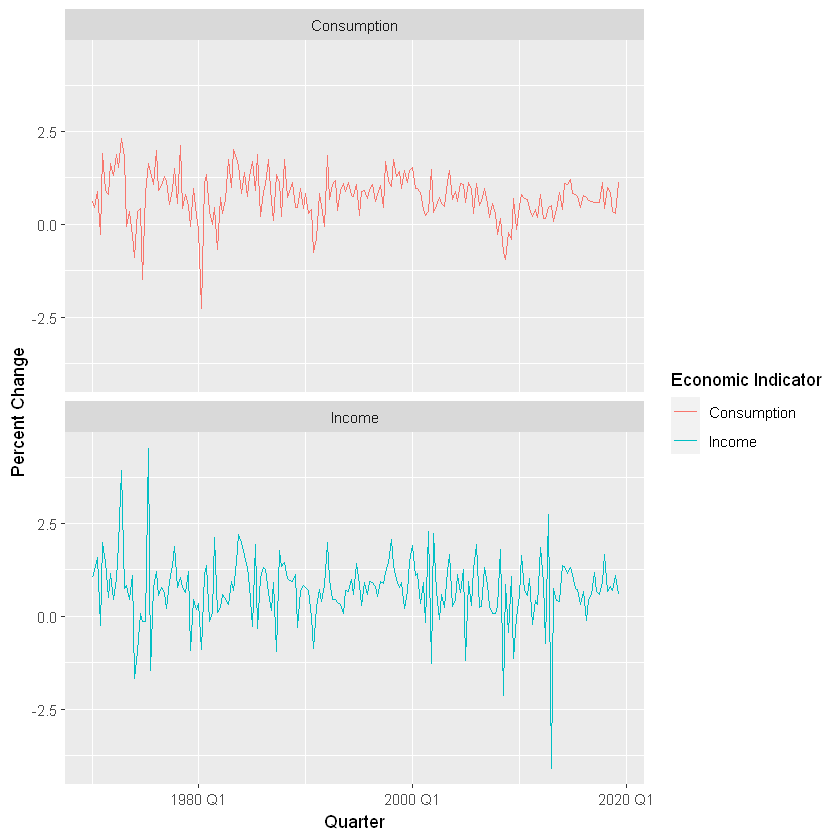

In [56]:
us_change %>%
select(-Production, -Savings, -Unemployment) %>%
pivot_longer(-Quarter, values_to = 'Percent Change', names_to = 'Economic Indicator') %>%
ggplot(aes(x=Quarter, y=`Percent Change`, colour=`Economic Indicator`, group=`Economic Indicator`)) +
geom_line() +
facet_wrap(`Economic Indicator`~., ncol=1)

ggsave(paste(plot_prefix, 'income_consumption.png', sep=''), height=6, width=5)

Plot of Income, Consumption, and Unemployment

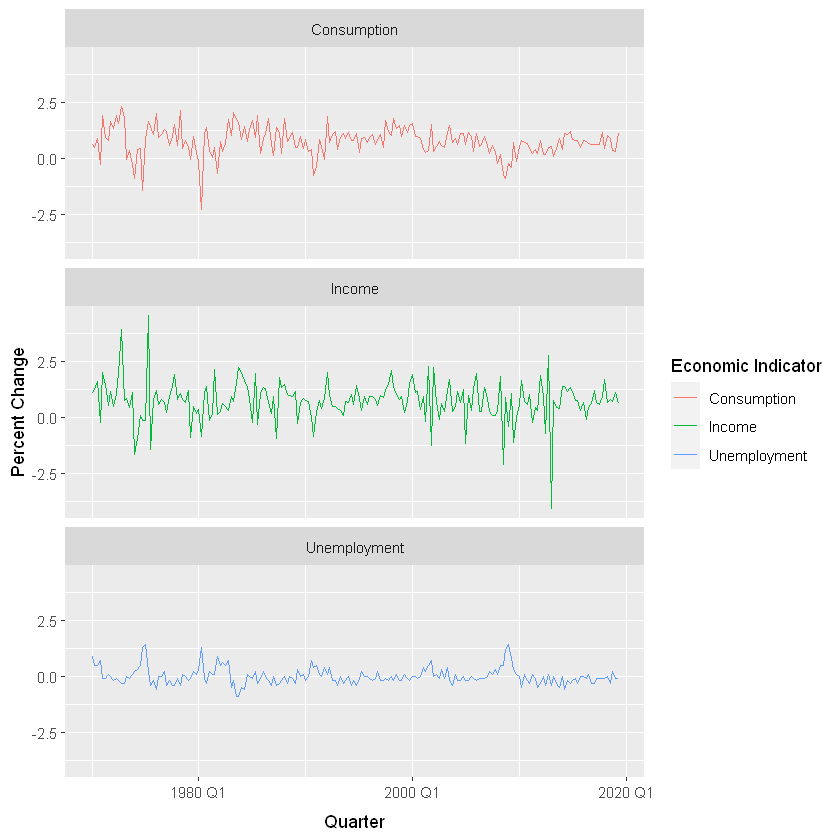

In [57]:
us_change %>%
select(-Production, -Savings) %>%
pivot_longer(-Quarter, values_to = 'Percent Change', names_to = 'Economic Indicator') %>%
ggplot(aes(x=Quarter, y=`Percent Change`, colour=`Economic Indicator`, group=`Economic Indicator`)) +
geom_line() +
facet_wrap(`Economic Indicator`~., ncol=1)

ggsave(paste(plot_prefix, 'income_consumption_unemployment.png', sep=''), height=6, width=5)

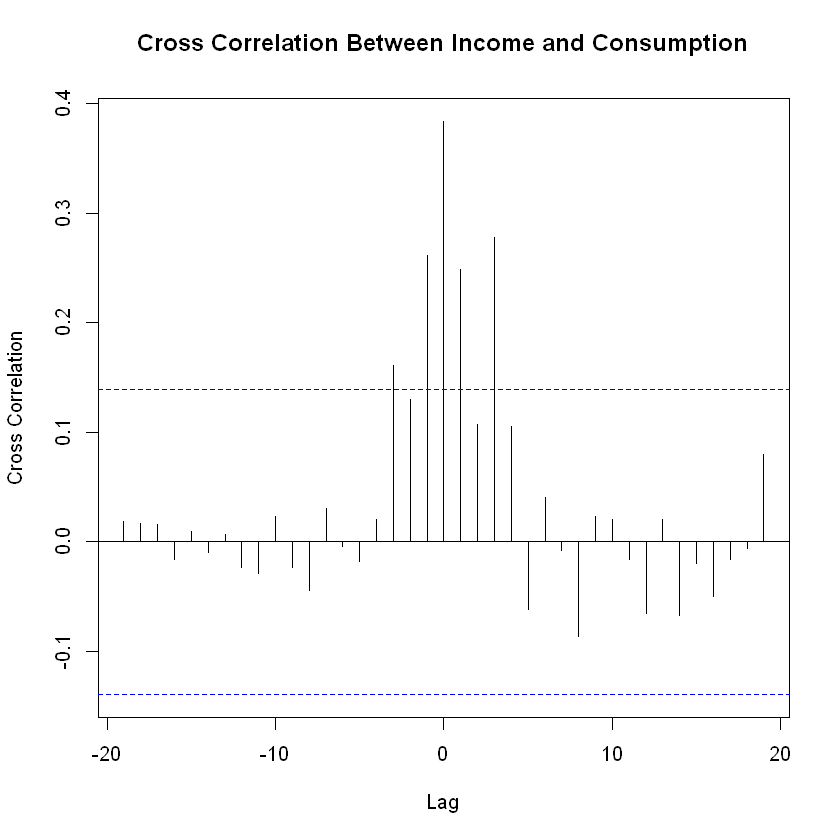

In [58]:
inc <- us_change$Income
con <- us_change$Consumption
ccf(inc, con, main='Cross Correlation Between Income and Consumption', type='correlation', ylab='Cross Correlation')

In [59]:
fit <- us_change |>
model(
aicc = fable::VAR(vars(Consumption, Income)),
bic = fable::VAR(vars(Consumption, Income), ic = "bic")
)

fit

aicc,bic
<model>,<model>
<VAR(5) w/ mean>,<VAR(1) w/ mean>


In [60]:
glance(fit)

.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>
aicc,"0.3195267, 0.1391537, 0.1391537, 0.6354455",-372.8583,797.7166,806.1744,882.5465
bic,"0.3601181, 0.1969693, 0.1969693, 0.7250800",-407.9293,835.8586,837.0414,868.6907


In [61]:
fit %>% select(aicc) %>% report()

Series: Consumption, Income 
Model: VAR(5) w/ mean 

Coefficients for Consumption:
      lag(Consumption,1)  lag(Income,1)  lag(Consumption,2)  lag(Income,2)
                  0.1864         0.1118              0.1658        -0.0117
s.e.              0.0771         0.0535              0.0792         0.0563
      lag(Consumption,3)  lag(Income,3)  lag(Consumption,4)  lag(Income,4)
                  0.3017        -0.0315             -0.0291        -0.0754
s.e.              0.0789         0.0551              0.0818         0.0552
      lag(Consumption,5)  lag(Income,5)  constant
                 -0.0492        -0.0433    0.3496
s.e.              0.0781         0.0529    0.0870

Coefficients for Income:
      lag(Consumption,1)  lag(Income,1)  lag(Consumption,2)  lag(Income,2)
                  0.4019        -0.2993              0.1024        -0.0449
s.e.              0.1087         0.0754              0.1117         0.0793
      lag(Consumption,3)  lag(Income,3)  lag(Consumption,4)  lag(I

In [62]:
fit %>% select(bic) %>% report()

Series: Consumption, Income 
Model: VAR(1) w/ mean 

Coefficients for Consumption:
      lag(Consumption,1)  lag(Income,1)  constant
                  0.2653         0.1130    0.4643
s.e.              0.0727         0.0514    0.0677

Coefficients for Income:
      lag(Consumption,1)  lag(Income,1)  constant
                  0.4919        -0.2576     0.550
s.e.              0.1031         0.0730     0.096

Residual covariance matrix:
            Consumption Income
Consumption      0.3601 0.1970
Income           0.1970 0.7251

log likelihood = -407.93
AIC = 835.86	AICc = 837.04	BIC = 868.69

Using BIC criteria will always select a model with fewer parameters than AICc due to the harsher parameter penalty.

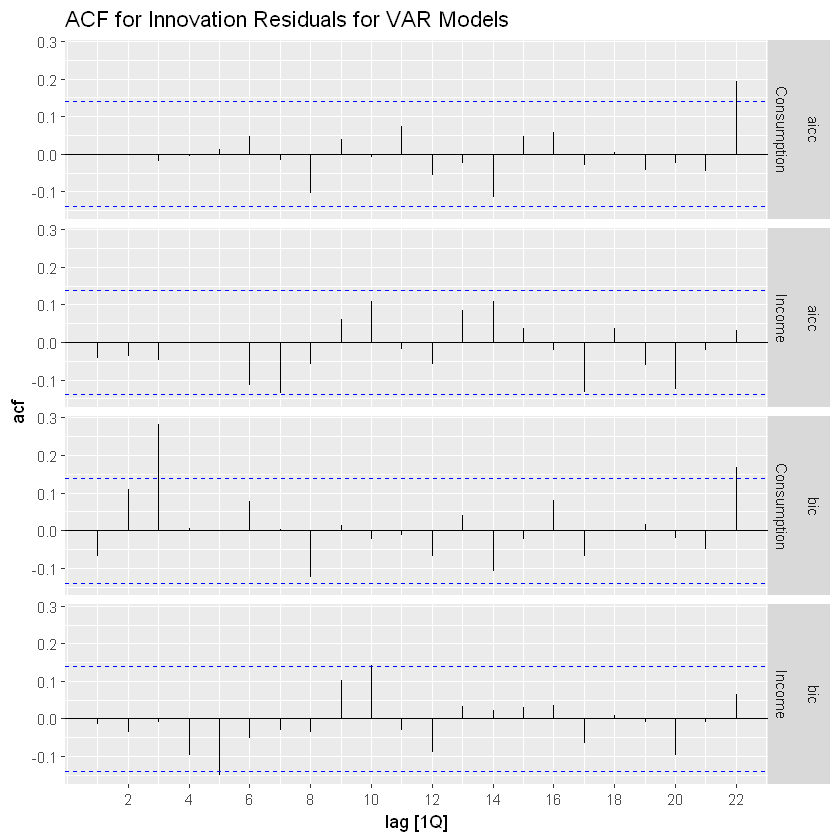

In [63]:
fit |>
  augment() |>
  ACF(.innov) |>
  autoplot() +
  labs(title='ACF for Innovation Residuals for VAR Models')

ggsave(paste(plot_prefix, 'income_consumption_unemployment.png', sep=''), height=6, width=5)

Fairly significant autocorrelation for Consumption at the third lag of the residuals.

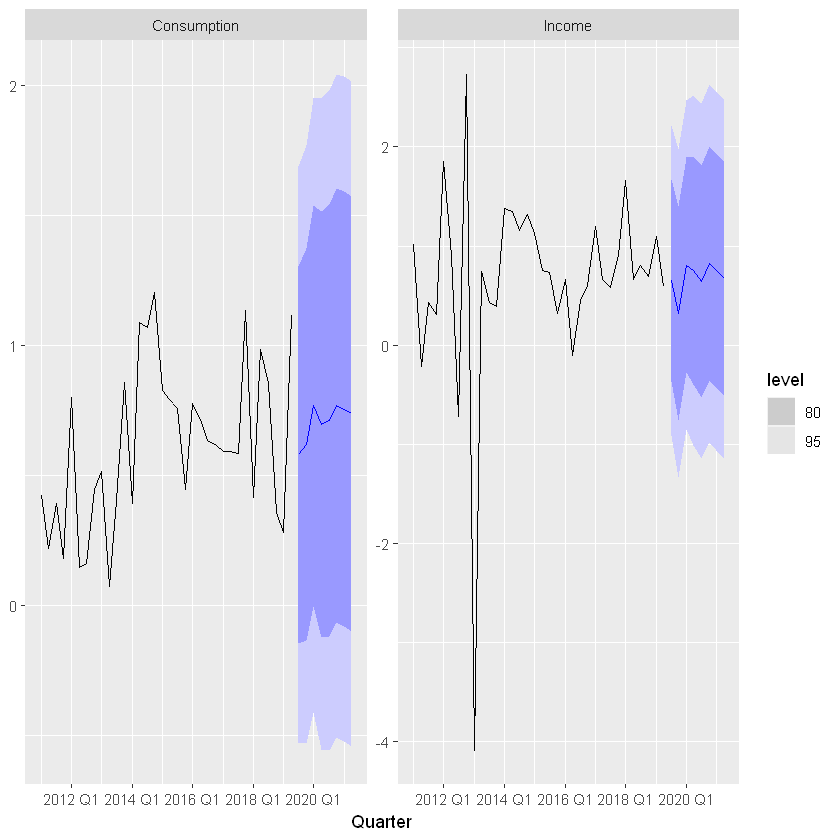

In [64]:
fit |>
  select(aicc) |>
  forecast() |>
  autoplot(us_change |> filter(year(Quarter) > 2010))

ggsave(paste(plot_prefix, 'income_consumption_forecasts.png', sep=''), height=8, width=8)

### Including External Regressors

In [65]:
fit <- us_change |>
model(var_with_xreg = VAR(vars(Consumption, Income) ~ xreg(Unemployment)))

fit

var_with_xreg
<model>
<VAR(5) w/ mean>


In [66]:
fit %>% report()

Series: Consumption, Income 
Model: VAR(5) w/ mean 

Coefficients for Consumption:
      lag(Consumption,1)  lag(Income,1)  lag(Consumption,2)  lag(Income,2)
                  0.0430         0.1106              0.0861         0.0103
s.e.              0.0758         0.0495              0.0747         0.0522
      lag(Consumption,3)  lag(Income,3)  lag(Consumption,4)  lag(Income,4)
                  0.2134        -0.0128             -0.0850        -0.0507
s.e.              0.0748         0.0511              0.0764         0.0513
      lag(Consumption,5)  lag(Income,5)  constant  Unemployment
                 -0.0427         0.0195    0.5182       -0.7252
s.e.              0.0724         0.0503    0.0860        0.1298

Coefficients for Income:
      lag(Consumption,1)  lag(Income,1)  lag(Consumption,2)  lag(Income,2)
                  0.3779        -0.2995               0.089        -0.0412
s.e.              0.1157         0.0756               0.114         0.0797
      lag(Consumption,3)

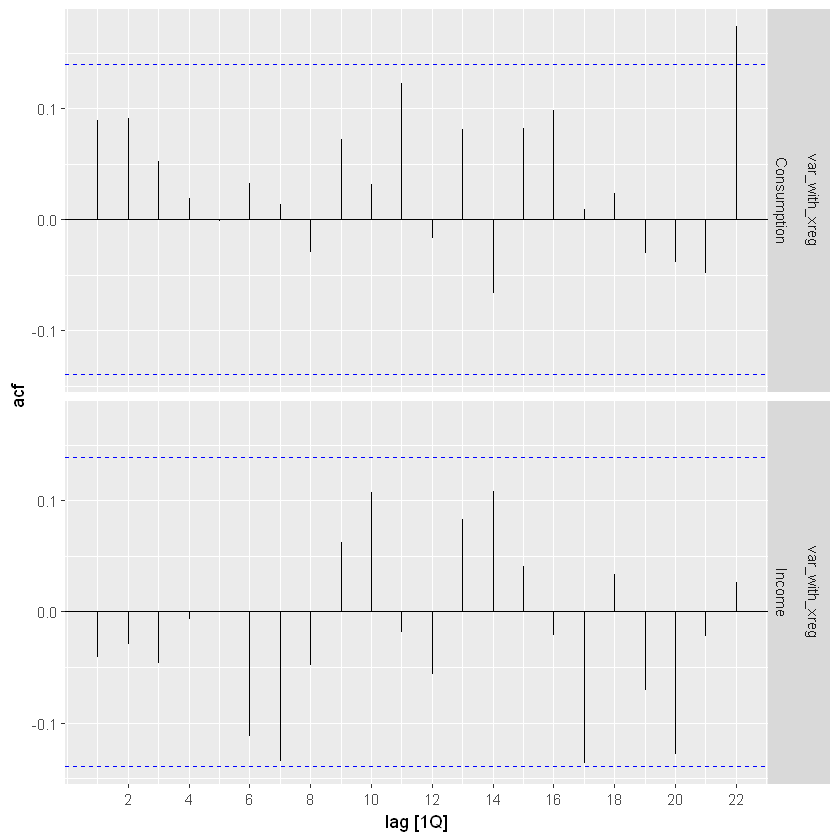

In [67]:
fit %>% augment() %>% ACF(.innov) %>% autoplot()

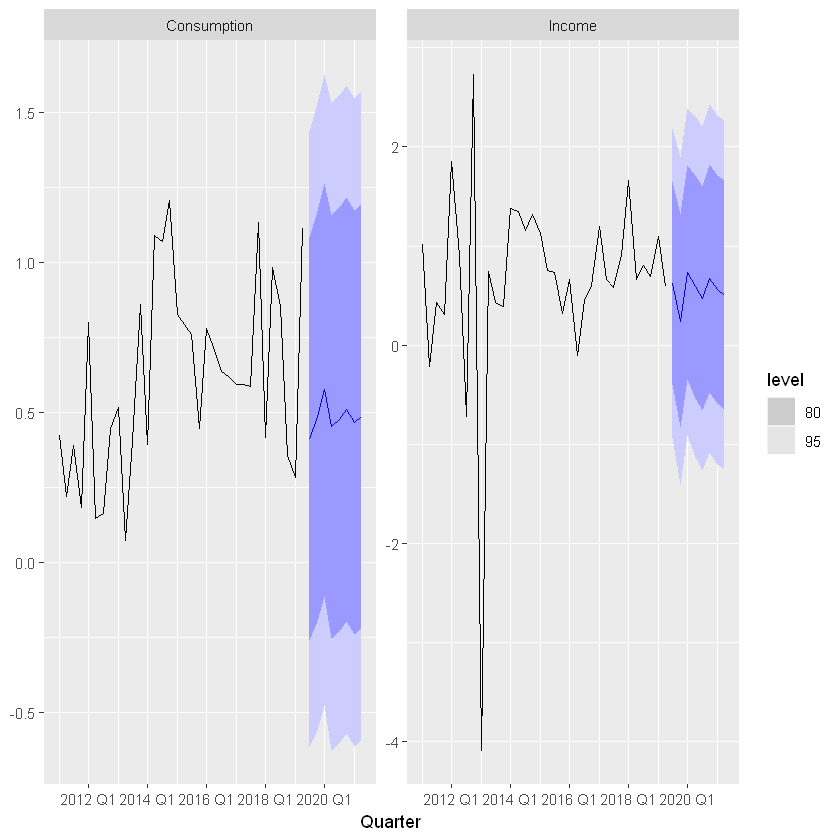

In [68]:
new_data_ex <- new_data(us_change, 8) %>% 
  mutate(Unemployment = .25)

fit |>
  forecast(new_data_ex) |>
  autoplot(us_change |> filter(year(Quarter) > 2010))

### Impulse Response Function
Need to use the `vars` package for this, but can provide some insight into the how long shocks in one series funnel and materialize to the other.

**There are some package conflicts between tidyverse, fable, and vars, need to be mindful of that potential and when in doubt, explicitly define the package and function via `package::function`**

In [69]:
suppressMessages(library(vars))

In [70]:
us_var <- us_change %>% dplyr::select(-Savings, -Production, -Unemployment) %>%
as.data.frame() %>%
dplyr::select(-Quarter) %>%
ts(start=c(1970,1), frequency = 4)

us_var %>% head()

Consumption,Income
0.6185664,1.0448013
0.4519840,1.2256472
0.8728718,1.5851538
-0.2718479,-0.2395449
1.9013450,1.9759249
0.9148773,1.4459085


In [71]:
var_length <- vars::VARselect(us_var)
var_length

,1,2,3,4,5,6,7,8,9,10
AIC(n),-1.4959327,-1.4863240,-1.5277019,-1.5398494,-1.5753599,-1.5506481,-1.5282562,-1.510674,-1.4720448,-1.4407631
HQ(n),-1.4540832,-1.4165748,-1.4300531,-1.4143009,-1.4219117,-1.3693002,-1.3190087,-1.273527,-1.2069979,-1.1478166
SC(n),-1.3926420,-1.3141728,-1.2866903,-1.2299773,-1.1966273,-1.1030550,-1.0118027,-0.925360,-0.8178704,-0.7177282
FPE(n),0.2240408,0.2262083,0.2170488,0.2144448,0.2069885,0.2122043,0.2170611,0.220980,0.2297738,0.2371907


In [72]:
var_fit <- vars::VAR(us_var, p=5)
summary(var_fit)


VAR Estimation Results:
Endogenous variables: Consumption, Income 
Deterministic variables: const 
Sample size: 193 
Log Likelihood: -372.858 
Roots of the characteristic polynomial:
0.7318 0.7318 0.6891 0.6891 0.6748 0.6175 0.6175 0.5529 0.5529 0.2118
Call:
vars::VAR(y = us_var, p = 5)


Estimation results for equation Consumption: 
Consumption = Consumption.l1 + Income.l1 + Consumption.l2 + Income.l2 + Consumption.l3 + Income.l3 + Consumption.l4 + Income.l4 + Consumption.l5 + Income.l5 + const 

               Estimate Std. Error t value Pr(>|t|)    
Consumption.l1  0.18636    0.07708   2.418 0.016598 *  
Income.l1       0.11183    0.05349   2.091 0.037942 *  
Consumption.l2  0.16579    0.07924   2.092 0.037806 *  
Income.l2      -0.01165    0.05626  -0.207 0.836165    
Consumption.l3  0.30168    0.07894   3.822 0.000182 ***
Income.l3      -0.03146    0.05507  -0.571 0.568552    
Consumption.l4 -0.02914    0.08182  -0.356 0.722150    
Income.l4      -0.07545    0.05520  -1.367 0.173

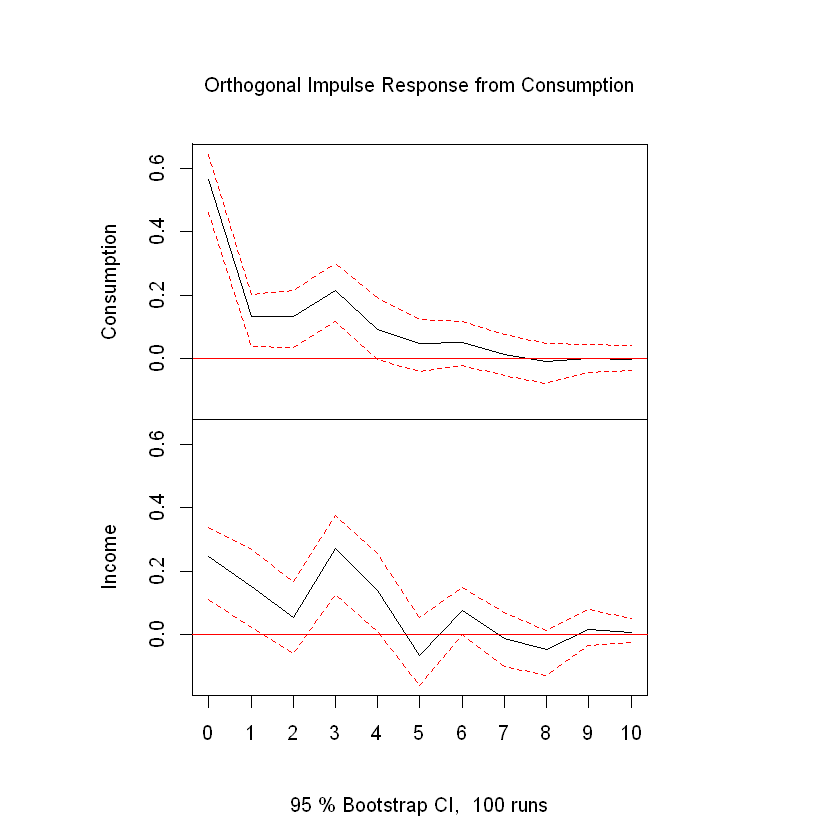

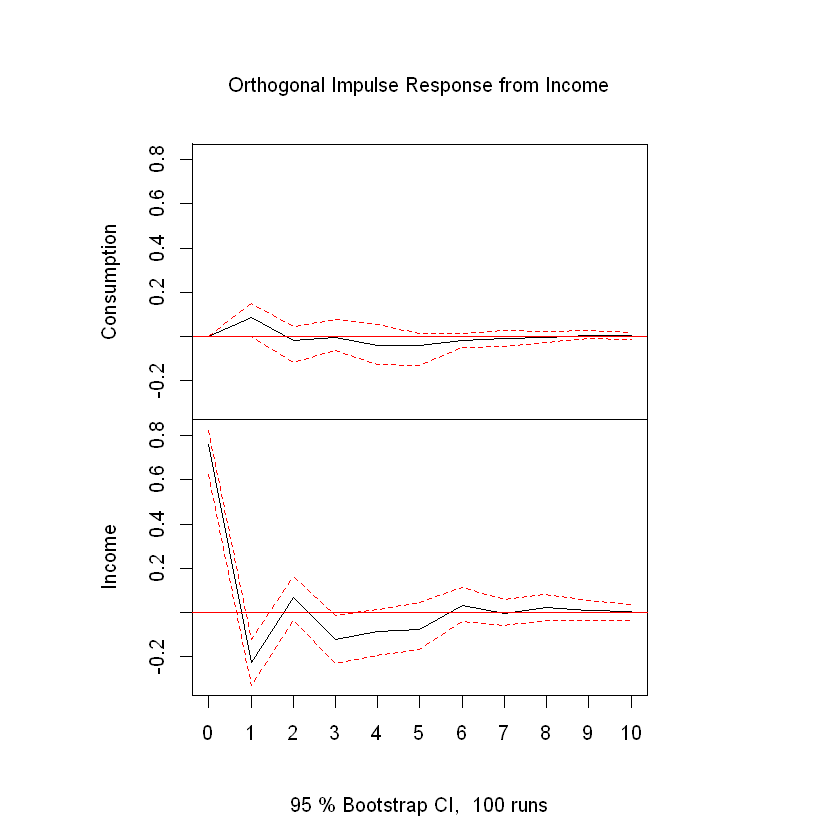

In [73]:
vars::irf(var_fit) %>% plot()

### Comparing Models with Housing Sales and Permits

In [74]:
sales <- read.csv('data/HSN1F.csv')
permits <- read.csv('data/PERMIT1.csv')

In [75]:
# Merge and create tsibble
housing <- sales %>%
inner_join(permits, by='DATE') %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
rename(MONTH=DATE, SALES=HSN1F, PERMITS=PERMIT1) %>%
as_tsibble(index = MONTH)

housing %>% head()

MONTH,SALES,PERMITS
<mth>,<dbl>,<dbl>
1963 Jan,591,695
1963 Feb,464,699
1963 Mar,461,738
1963 Apr,605,777
1963 May,586,740
1963 Jun,526,771


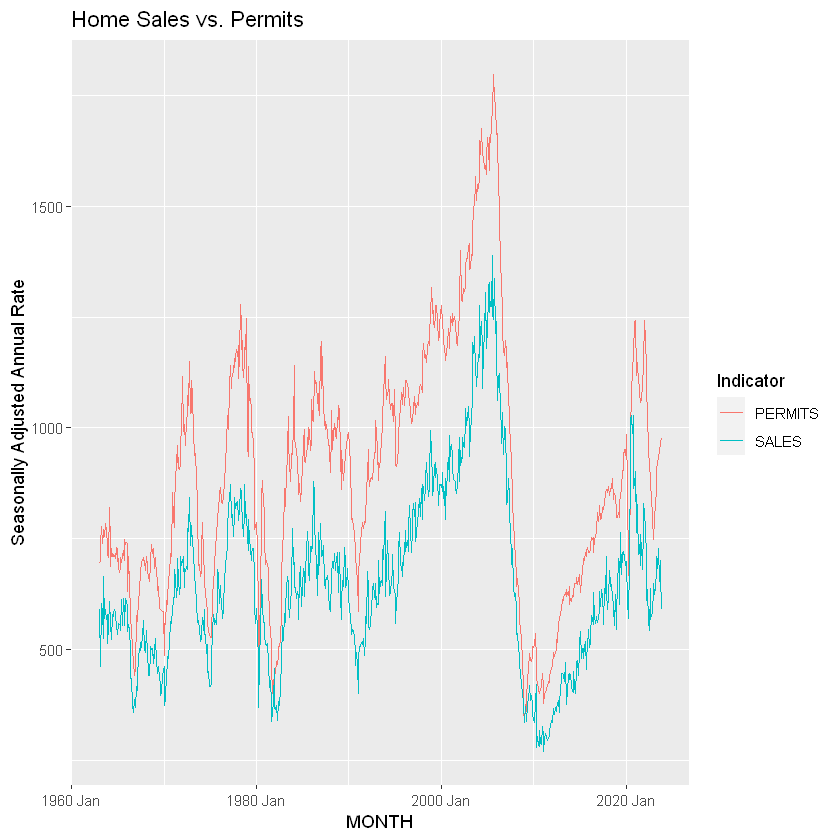

In [76]:
housing %>%
pivot_longer(-MONTH, values_to = 'Homes', names_to='Indicator') %>%
ggplot(aes(x=MONTH, y=Homes, group=Indicator, colour=Indicator)) +
geom_line() +
labs(title = 'Home Sales vs. Permits', y='Seasonally Adjusted Annual Rate')

ggsave(paste(plot_prefix, 'housing_sales_permits.png', sep=''), height=4, width=6)

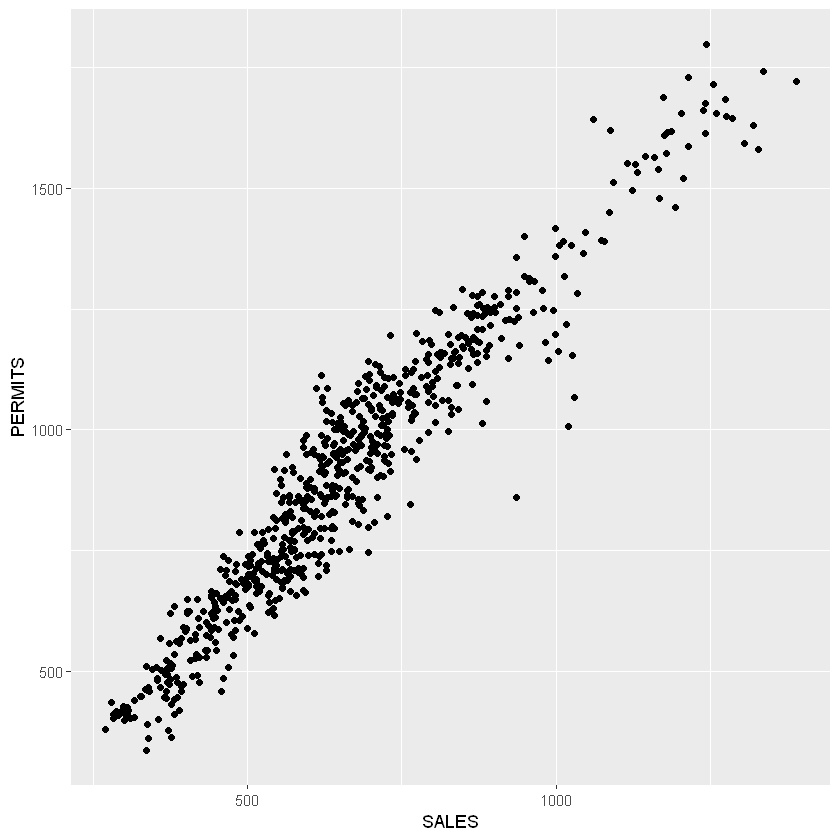

In [77]:
housing %>%
ggplot(aes(x=SALES, y=PERMITS)) +
geom_point()

ggsave(paste(plot_prefix, 'housing_sales_scatter.png', sep=''), height=6, width=6)

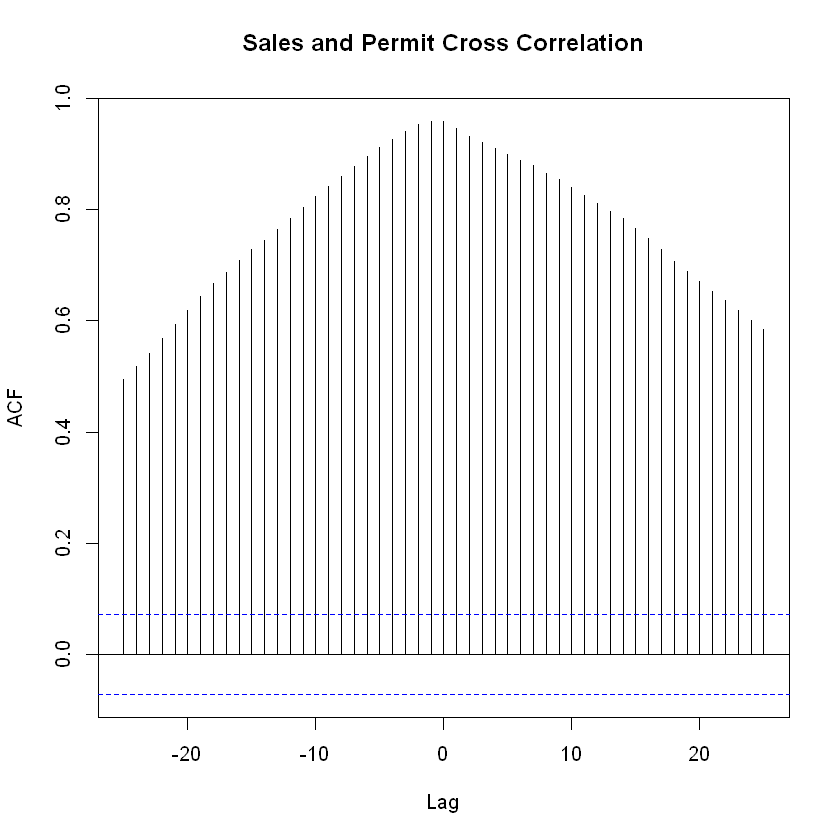

In [78]:
sales_vec <- housing$SALES
permits_vec <- housing$PERMITS

ccf(sales_vec, permits_vec, type='correlation', main='Sales and Permit Cross Correlation')

In [79]:
# Split the data for training and test
housing_training <- housing %>% filter_index('2000 Jan' ~ '2021 Dec')
housing_test <- housing %>% filter_index('2022 Jan' ~ .)

# ARIMA, ETS Models
sales_univariate <- housing_training %>%
model(
    'ets_sales' = ETS(SALES),
    'arima_sales' = ARIMA(SALES)
    )

sales_univariate_forecasts <- sales_univariate %>% forecast(housing_test)
sales_univariate_forecasts %>% accuracy(housing)


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arima_sales,Test,-160.1968,173.3382,160.1968,-25.86635,25.86635,1.636413,1.358988,0.5600226
ets_sales,Test,-162.1443,175.1396,162.1443,-26.16852,26.16852,1.656306,1.373111,0.5600226


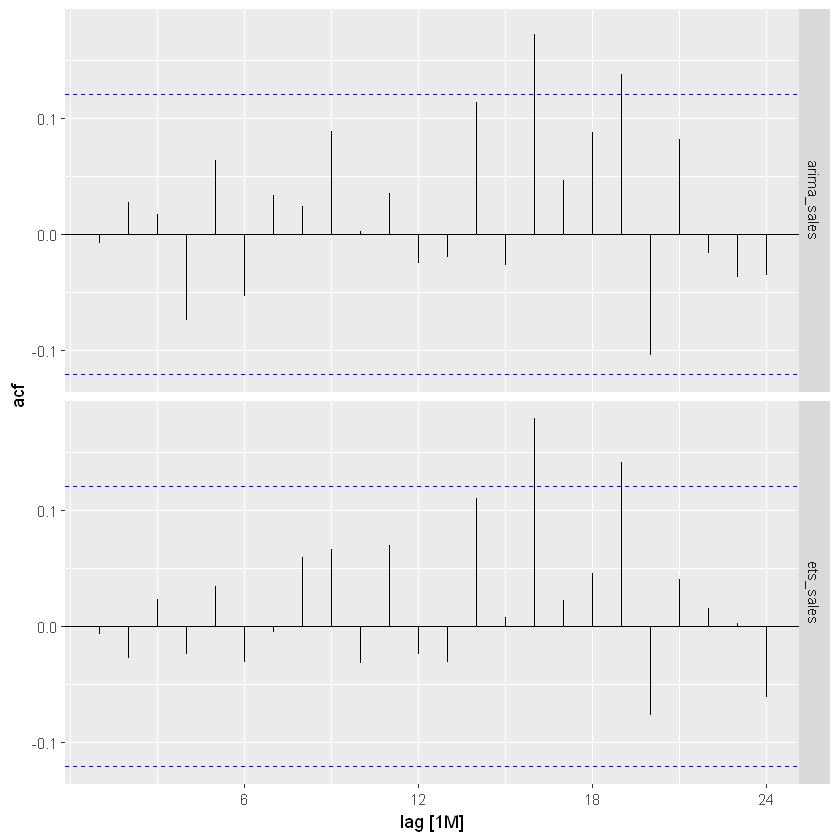

In [80]:
sales_univariate %>% augment() %>% ACF(.innov) %>% autoplot()

In [81]:
sales_univariate %>% dplyr::select(arima_sales) %>% report()

Series: SALES 
Model: ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.2434
s.e.   0.0587

sigma^2 estimated as 2688:  log likelihood=-1411.11
AIC=2826.22   AICc=2826.27   BIC=2833.37


In [82]:
sales_univariate %>% dplyr::select(ets_sales) %>% report()

Series: SALES 
Model: ETS(M,N,N) 
  Smoothing parameters:
    alpha = 0.7776637 

  Initial states:
     l[0]
 865.2056

  sigma^2:  0.0055

     AIC     AICc      BIC 
3515.623 3515.715 3526.351 


In [83]:
permits_univariate <- housing_training %>%
model(
    'ets_permits' = ETS(PERMITS),
    'arima_permits' = ARIMA(PERMITS)
    )

permits_univariate_forecasts <- permits_univariate %>% forecast(housing_test)
permits_univariate_forecasts %>% accuracy(housing)


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arima_permits,Test,-285.9082,316.5466,295.4447,-32.87737,33.65043,2.202426,1.764972,0.7851202
ets_permits,Test,-227.5767,263.3402,239.2248,-26.57058,27.51946,1.783329,1.468309,0.8300237


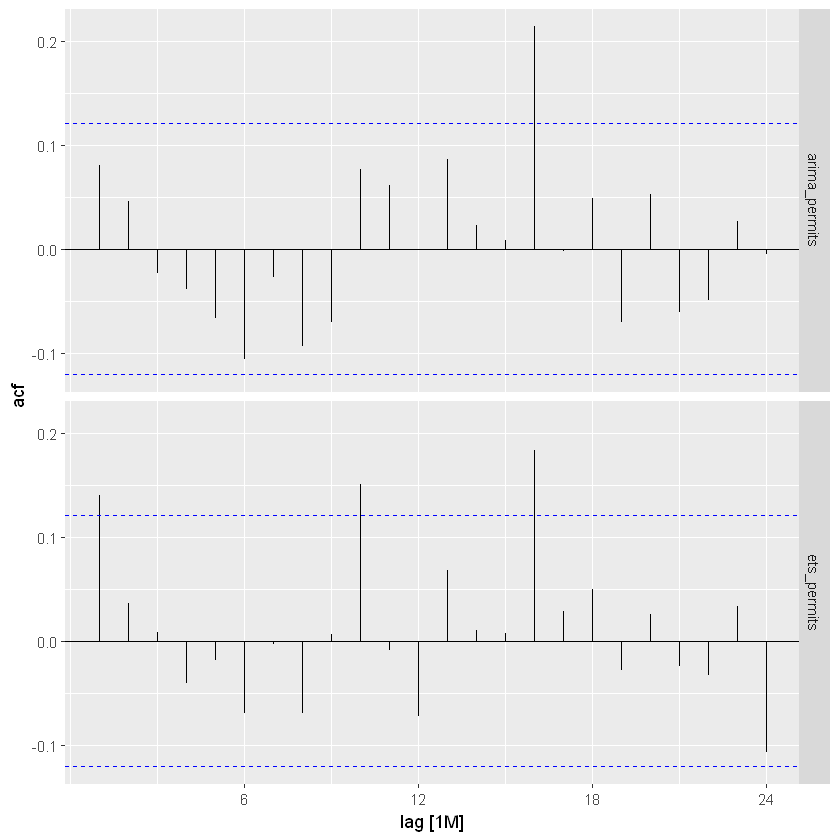

In [84]:
permits_univariate %>% augment() %>% ACF(.innov) %>% autoplot()

In [85]:
permits_univariate %>% dplyr::select(arima_permits) %>% report()

Series: PERMITS 
Model: ARIMA(1,1,1)(0,0,2)[12] 

Coefficients:
         ar1      ma1     sma1     sma2
      0.9564  -0.8634  -0.1592  -0.1684
s.e.  0.0359   0.0637   0.0671   0.0825

sigma^2 estimated as 1339:  log likelihood=-1318.56
AIC=2647.11   AICc=2647.35   BIC=2664.97


ARIMA seems better for sales, while ETS seems better for permits.

In [86]:
permits_univariate %>% dplyr::select(ets_permits) %>% report()

Series: PERMITS 
Model: ETS(M,Ad,N) 
  Smoothing parameters:
    alpha = 0.9998815 
    beta  = 0.1089546 
    phi   = 0.8000016 

  Initial states:
     l[0]      b[0]
 1250.196 -6.074094

  sigma^2:  0.0018

     AIC     AICc      BIC 
3382.101 3382.428 3403.556 


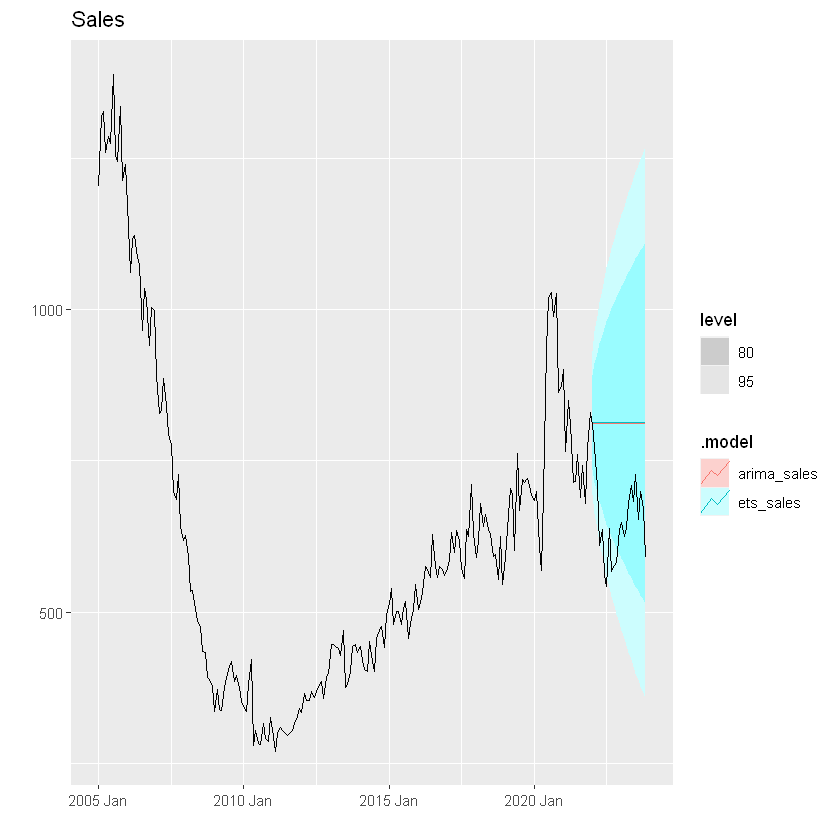

In [87]:
# Sales
sales_univariate_forecasts %>% autoplot(housing |> filter(year(MONTH) >= 2005)) + labs(title='Sales', y='', x='')

ggsave(paste(plot_prefix, 'housing_sales_forecast.png', sep=''), height=3, width=6)

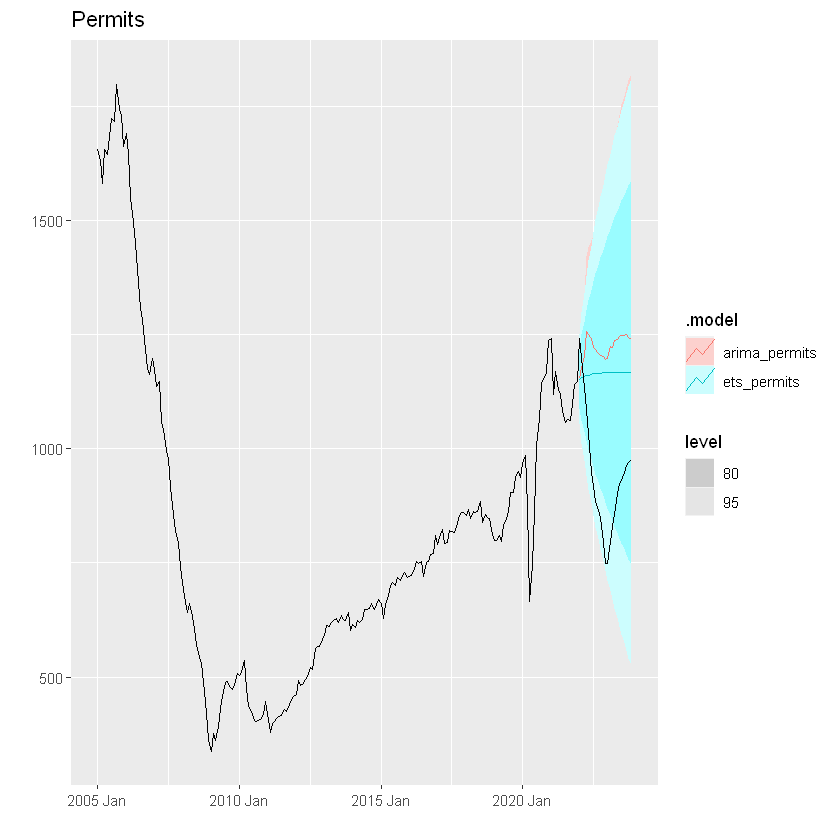

In [88]:
# Permits
permits_univariate_forecasts %>% autoplot(housing |> filter(year(MONTH) >= 2005)) + labs(title='Permits', y='', x='')

ggsave(paste(plot_prefix, 'housing_permits_forecast.png', sep=''), height=3, width=6)

In [89]:
housing_var <- housing_training |>
model(
aicc = fable::VAR(vars(SALES, PERMITS)),
bic = fable::VAR(vars(SALES, PERMITS), ic = "bic")
)

housing_var %>% glance()

.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>
aicc,"2536.555, 825.718, 825.718, 1244.312",-2631.25,5310.5,5315.629,5395.864
bic,"2536.555, 825.718, 825.718, 1244.312",-2631.25,5310.5,5315.629,5395.864


In [91]:
housing_var %>% dplyr::select(bic) %>% report()

Series: SALES, PERMITS 
Model: VAR(5) 

Coefficients for SALES:
      lag(SALES,1)  lag(PERMITS,1)  lag(SALES,2)  lag(PERMITS,2)  lag(SALES,3)
            0.6285          0.3744        0.2404         -0.4541       -0.0152
s.e.        0.0710          0.0993        0.0814          0.1333        0.0821
      lag(PERMITS,3)  lag(SALES,4)  lag(PERMITS,4)  lag(SALES,5)
              0.1926       -0.0892         -0.0104        0.0076
s.e.          0.1361        0.0809          0.1362        0.0729
      lag(PERMITS,5)
              0.0674
s.e.          0.0920

Coefficients for PERMITS:
      lag(SALES,1)  lag(PERMITS,1)  lag(SALES,2)  lag(PERMITS,2)  lag(SALES,3)
            0.1586          0.9655        0.1308         -0.0595       -0.0713
s.e.        0.0497          0.0695        0.0570          0.0934        0.0575
      lag(PERMITS,3)  lag(SALES,4)  lag(PERMITS,4)  lag(SALES,5)
              0.0605       -0.0207          0.0282       -0.1408
s.e.          0.0953        0.0567          0.0

In [92]:
housing_var_forecasts <- housing_var %>%
dplyr::select(bic) %>%
forecast(housing_test)

housing_var_forecasts %>% accuracy(housing)

.model,.response,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bic,PERMITS,Test,-283.2877,316.7969,290.9800,-32.73886,33.36189,2.169144,1.766367,0.8171198
bic,SALES,Test,-239.5888,251.9856,239.5888,-38.26599,38.26599,2.447403,1.975591,0.5533544


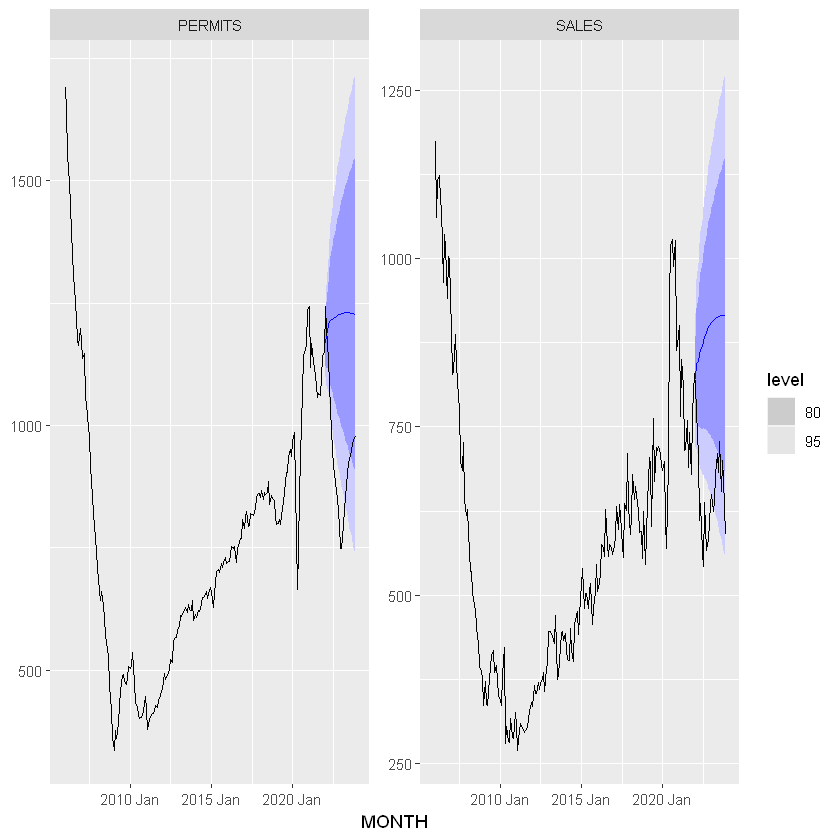

In [93]:
housing_var_forecasts %>% autoplot(housing |> filter(year(MONTH) > 2005))

ggsave(paste(plot_prefix, 'housing_var_forecast.png', sep=''), height=3, width=6)

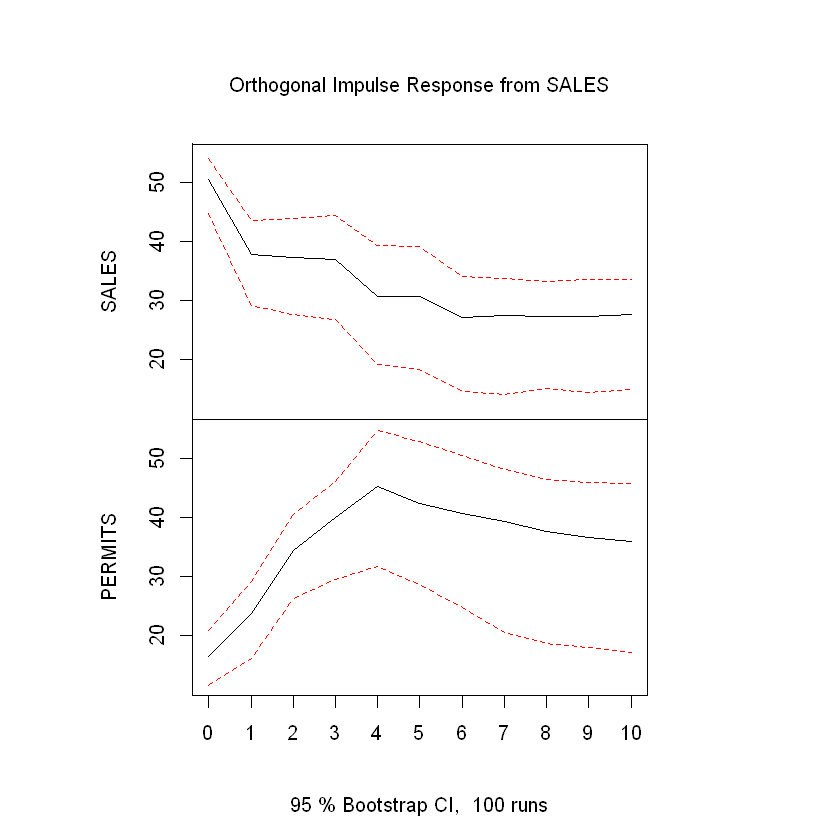

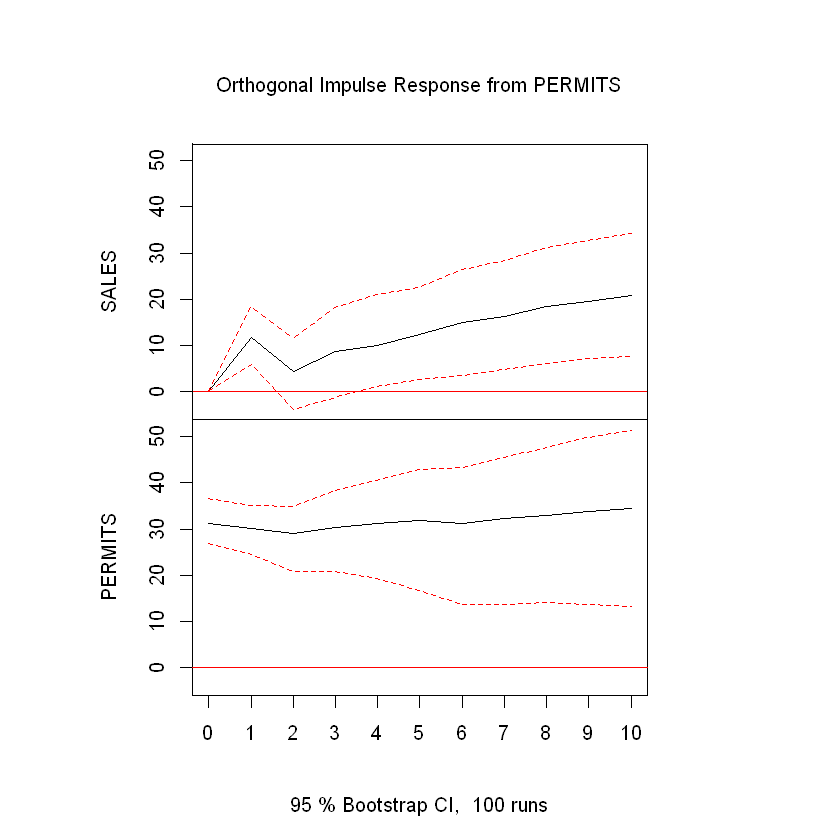

In [95]:
housing_training_df <- housing_training %>% as.data.frame() %>% dplyr::select(-MONTH)

var_fit_housing <- vars::VAR(housing_training_df, p=5)
vars::irf(var_fit_housing) %>% plot()

#### Potential Factors Explaining the Sudden drop in activity?

In [96]:
mortg <- read.csv('data/MORTGAGE30US.csv')
mortg %>% head(1)

,DATE,MORTGAGE30US
,<chr>,<dbl>
1,1971-04-01,7.31


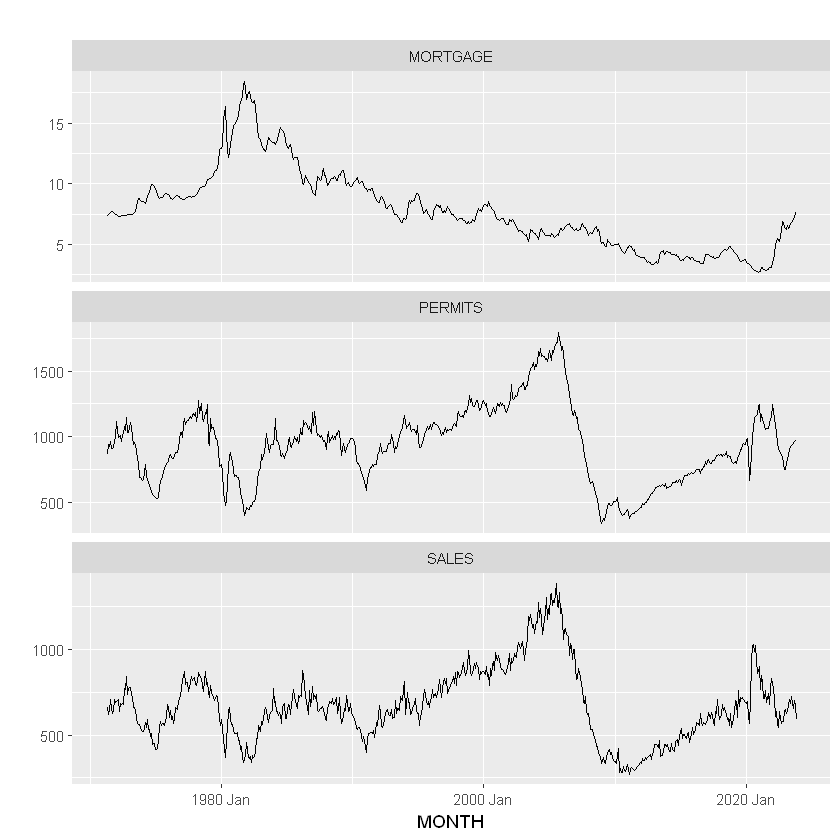

In [97]:
# Merge and create tsibble
housing <- sales %>%
inner_join(permits, by='DATE') %>%
inner_join(mortg, by='DATE') %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
rename(MONTH=DATE, SALES=HSN1F, PERMITS=PERMIT1, MORTGAGE = MORTGAGE30US) %>%
as_tsibble(index = MONTH)

housing %>%
pivot_longer(-MONTH, values_to = 'Homes', names_to='Indicator') %>%
ggplot(aes(x=MONTH, y=Homes, group=Indicator)) +
geom_line() +
facet_wrap(.~Indicator, ncol=1, scales='free_y') +
labs(title = '', y='')

Traditionally, the change in the mortgage rates is the driving factor of activity.

In [98]:
housing <- housing %>% mutate(RATE_CHG = difference(MORTGAGE))

In [99]:
# Split the data for training and test
housing_training <- housing %>% filter_index('2000 Jan' ~ '2021 Dec')
housing_test <- housing %>% filter_index('2022 Jan' ~ .)

housing_var <- housing_training |>
model(
aicc = fable::VAR(vars(SALES, PERMITS) ~ xreg(RATE_CHG)),
bic = fable::VAR(vars(SALES, PERMITS) ~ xreg(RATE_CHG), ic = "bic")
)

housing_var %>% glance()

.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>
aicc,"2525.3913, 822.2629, 822.2629, 1247.1774",-2630.158,5312.315,5318.367,5404.793
bic,"2525.3913, 822.2629, 822.2629, 1247.1774",-2630.158,5312.315,5318.367,5404.793


In [100]:
housing_var_forecasts <- housing_var %>%
dplyr::select(bic) %>%
forecast(housing_test)

housing_var_forecasts %>% accuracy(housing)

.model,.response,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bic,PERMITS,Test,-221.3658,252.8796,229.8975,-25.75268,26.44501,1.669247,1.374842,0.8147411
bic,SALES,Test,-185.2517,196.9252,185.2517,-29.72577,29.72577,1.847134,1.509732,0.5545485


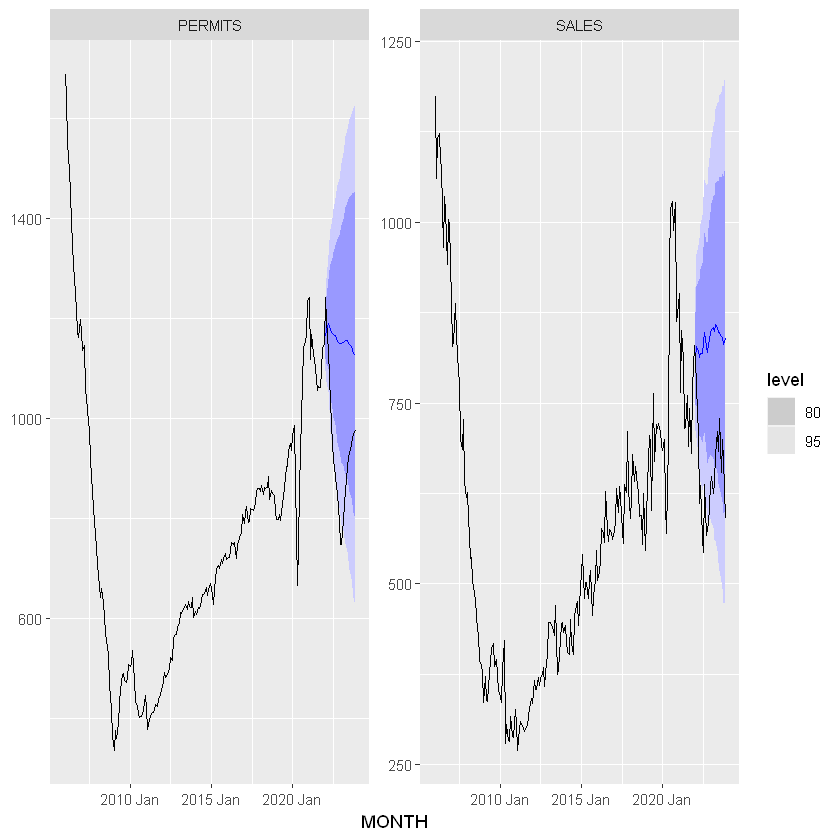

In [101]:
housing_var_forecasts %>% autoplot(housing |> filter(year(MONTH) > 2005))

Even with perfect information about the future of interest rates, still would not have accurately forecasted the drop in activity. Might be a case where judgement could have been used and/or broader housing health analysis to signal that fundamentals are stretched.

Also shows that while the point forecast was relatively poor, the actuals would have been captured within the prediction intervals.